In [1]:
import pickle 
import os
from pathlib import Path
import numpy as np
import sys
sys.path.append('../')

# Load the data from the pickle files

In [2]:
raghav_ec_path = Path('../test_data/sashi_eyes_closed/') # Path to raghav's Eyes closed data
raghav_w_path = Path('../test_data/sashi_work/') # Path to raghavs Work Data

In [3]:
# This function will load the data from all the pickle files in the given path
def load_all_pickle_files(path,vstack=False):
    # If vstack is true, then it will combine data of all files into a single numpy array
    # by stacking them one upon other
    path = Path(path)
    data = []
    for file in os.listdir(path):
        if 'pickle' in file:
            print(f"Loading File: {file}")
            with open(path/file,'rb') as f_:
                d = pickle.load(f_)
                data.append(d)
       
    if(vstack == True):
        data = np.vstack(data)
    else:
        data = np.array(data)
    return data

In [4]:
raghav_ec_data = load_all_pickle_files(raghav_ec_path) # Data for eyes closed
raghav_w_data = load_all_pickle_files(raghav_w_path) # Data for work

Loading File: [f]sashi_EYES_CLOSED|171019_172659.pickle
Loading File: [f]sashi_EYES_CLOSED|181019_164552.pickle
Loading File: [f]sashi_eyes_closed|151019_135421.pickle
Loading File: [f]sashi_EYES_CLOSED|181019_163555.pickle
Loading File: [f]sashi_assignment|151019_140830.pickle
Loading File: [f]sashi_ATTENTION|171019_173817.pickle
Loading File: [f]sashi_ATTENTION|181019_145457.pickle
Loading File: [f]sashi_ATTENTION|181019_144315.pickle


# Plot the data

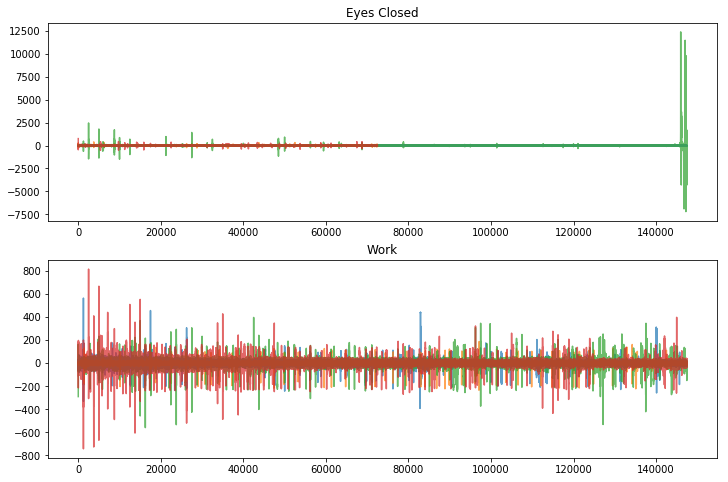

In [5]:
# Plot the filtered (DC and 50Hz notch) data without removing bad epochs
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2,1, figsize=(12,8))

for dt in raghav_ec_data:
    ax[0].plot(dt[10:,0,:].reshape(-1), alpha=0.7)
    ax[0].set_title('Eyes Closed')

for dt in raghav_w_data:
    ax[1].plot(dt[10:,0,:].reshape(-1), alpha=0.7)
    ax[1].set_title('Work')

# Remove Bad Epochs

In [6]:
from features import feature_removal as fr
import config

def clean_data(*args, threshold=400):
    ''' This funtion will clean up the data and remove bad epochs based on the threshold'''
    ''' Each numpy array passed as an argument is treated as a seperate data file and then processed'''
    
    clean_data = []
    
    for i, data_file in enumerate(args):
        print(f"Processing file:{i+1}")
        clean_data_file = []
        for d in data_file:
            config.reset_filter_states()
            clean_data_file.append(fr.remove_bad_epochs(d,fr.energy_of_epoch,threshold=threshold))
        clean_data.append(np.array(clean_data_file))
        
    return clean_data

Using config.dataReader - random number


In [7]:
raghav_ec_clean, raghav_w_clean = clean_data(raghav_ec_data,raghav_w_data)

Processing file:1
Processing file:2


In [8]:
print("New shapes of clean EC data")
for d in raghav_ec_clean:
    print(d.shape)

print("New shapes of clean Work data")
for d in raghav_w_clean:
    print(d.shape)

New shapes of clean EC data
(1197, 1, 250)
(575, 1, 250)
(1031, 1, 250)
(505, 1, 250)
New shapes of clean Work data
(1119, 1, 250)
(1123, 1, 250)
(1050, 1, 250)
(823, 1, 250)


# Get the bandpower percentage of the data
See how much each band contributes to the overall bandpower.
The get_bandpower function has a parameter called relative. If you set it as True, then the 
function will calculate the bandpower percentage instead of overall bandpower

# Bandpower per epoch
The below code will calculate bandpower per epoch. 

In [9]:
from features import get_bandpower
config.reset_filter_states()
def bandpower(*args,per_epochs=1,relative=False):
    ''' You can give as many files as you want an this function will find the 
        bandpower for each of them and return them as a list '''
    ''' If relative is True, then bandpower percentage for each band will be calculated'''
    ''' Per epochs refers to how many epochs together will be used to find bandpower.'''
    
    _bandpower = []
    for j, data in enumerate(args):
        print(f"Processing file:{j+1}")
        idxs = list(range(0,data.shape[0],per_epochs))
        _b = []
        for i in idxs:
            _b.append(get_bandpower(data[i:i+per_epochs],relative=relative))
        _bandpower.append(np.array(_b))
    
    return _bandpower


In [11]:
raghav_ec_bandpower_percentage = bandpower(*raghav_ec_clean,per_epochs=5,relative=False)
raghav_w_bandpower_percentage = bandpower(*raghav_w_clean,per_epochs=5,relative=False)

Processing file:1
Processing file:2
Processing file:3
Processing file:4
Processing file:1
Processing file:2
Processing file:3
Processing file:4


In [12]:
print("Data shape of EC bandpower Percentage: ")
for d in raghav_ec_bandpower_percentage:
    print(d.shape)
    
print("Data shape of Work bandpower Percentage: ")
for d in raghav_w_bandpower_percentage:
    print(d.shape)

Data shape of EC bandpower Percentage: 
(240, 1, 5)
(115, 1, 5)
(207, 1, 5)
(101, 1, 5)
Data shape of Work bandpower Percentage: 
(224, 1, 5)
(225, 1, 5)
(210, 1, 5)
(165, 1, 5)


# Plotting the bandpower percentage for eyes closed data first

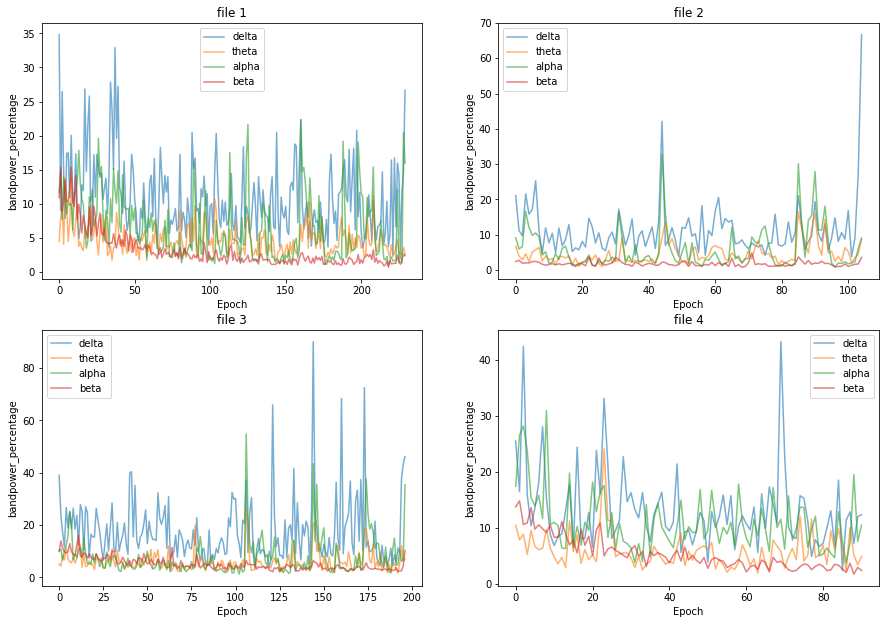

In [13]:
import matplotlib.pyplot as plt
bands = ['delta','theta','alpha','beta']

fig = plt.figure(figsize=(15,16))
nrows = len(raghav_ec_bandpower_percentage)//2 + 1 # // is the same as divide and do math.floor
ncols = 2

for i, b in enumerate(raghav_ec_bandpower_percentage):
    ax = fig.add_subplot(nrows,ncols,i+1)
    for j, band_ in enumerate(bands):
        ax.plot(b[10:340,:,j].reshape(-1), alpha=0.6, label=bands[j])
        ax.set_title(f"file {i+1}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('bandpower_percentage')
        ax.legend()


# Plot bandpower percentage for Work Data

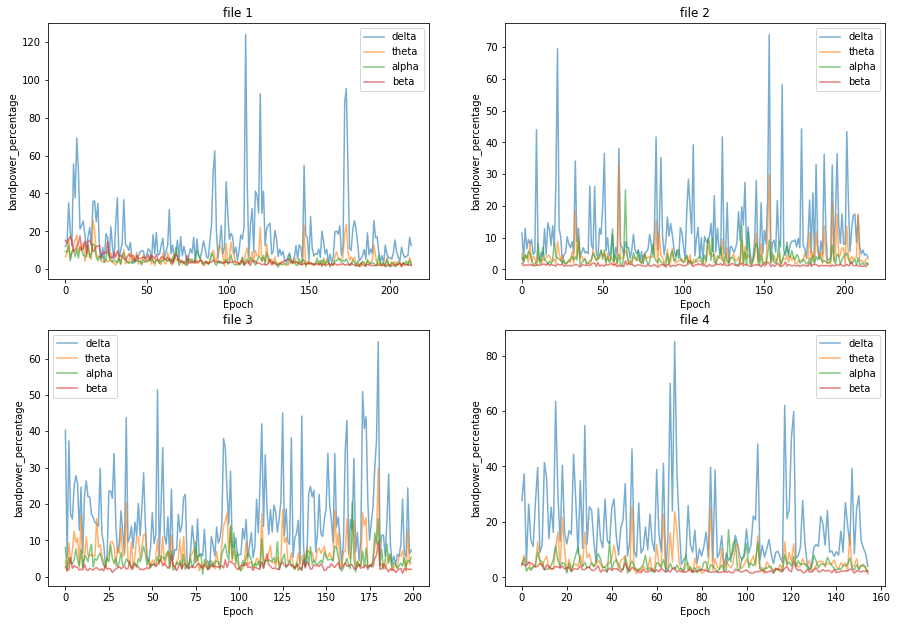

In [14]:
fig = plt.figure(figsize=(15,16))
nrows = len(raghav_w_bandpower_percentage)//2 + 1 # // is the same as divide and do math.floor
ncols = 2

for i, b in enumerate(raghav_w_bandpower_percentage):
    ax = fig.add_subplot(nrows,ncols,i+1)
    for j, band_ in enumerate(bands):
        ax.plot(b[10:340,:,j].reshape(-1), alpha=0.6, label=bands[j])
        ax.set_title(f"file {i+1}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('bandpower_percentage')
        ax.legend()

# Plot the histograms of all Eyes closed first

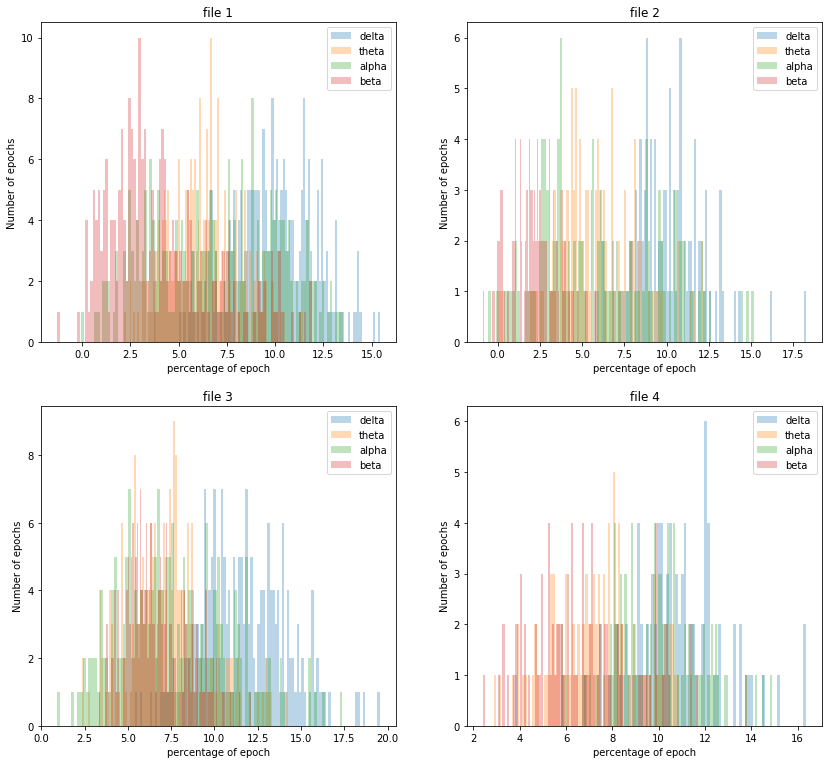

In [15]:
fig = plt.figure(figsize=(14,20))
nrows = len(raghav_ec_bandpower_percentage)//2 + 1 # // is the same as divide and do math.floor
ncols = 2

for i, b in enumerate(raghav_ec_bandpower_percentage):
    ax = fig.add_subplot(nrows,ncols,i+1)
    for j, band_ in enumerate(bands):
        ax.hist(10*np.log10(b[10:340,:,j].reshape(-1)),bins=100,
                       density=False, alpha=0.3, label=bands[j])
        ax.set_title(f"file {i+1}")
        ax.set_xlabel('percentage of epoch')
        ax.set_ylabel('Number of epochs')
        ax.legend()

# Plot histograms of work data

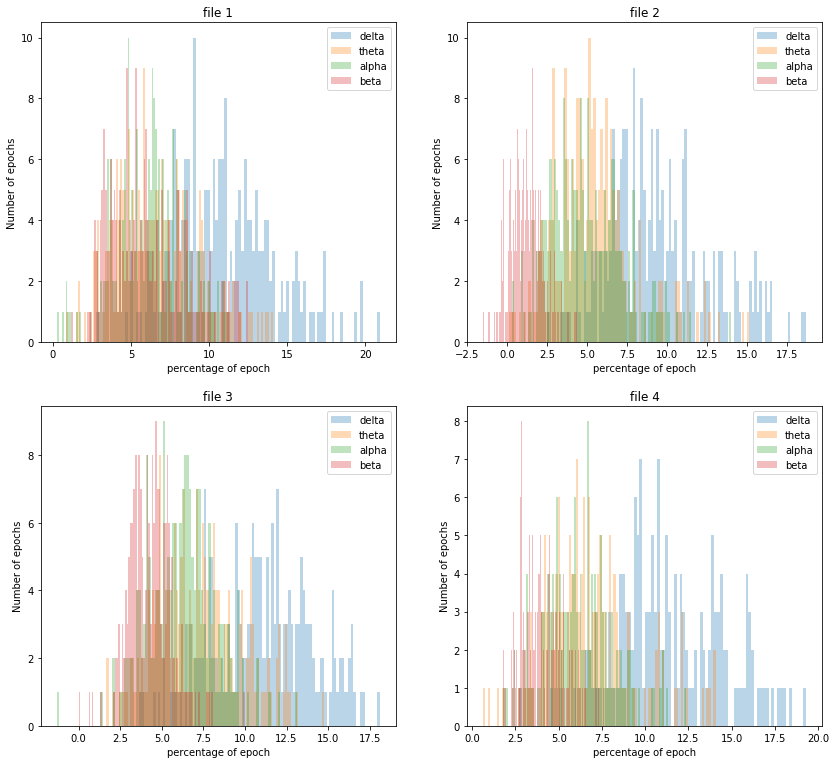

In [16]:
fig = plt.figure(figsize=(14,20))
nrows = len(raghav_w_bandpower_percentage)//2 + 1 # // is the same as divide and do math.floor
ncols = 2

for i, b in enumerate(raghav_w_bandpower_percentage):
    ax = fig.add_subplot(nrows,ncols,i+1)
    for j, band_ in enumerate(bands):
        ax.hist(10*np.log10(b[10:340,:,j].reshape(-1)),bins=100,
                       density=False, alpha=0.3, label=bands[j])
        ax.set_title(f"file {i+1}")
        ax.set_xlabel('percentage of epoch')
        ax.set_ylabel('Number of epochs')
        ax.legend()